# TensorFlow Datasets 

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tf/01-nn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

## Introduction

To train neural networks, we typically need to stream large amounts of input data  &mdash; sometimes too large to fit in computer memory. In this case, it would not be possible to simply use `fit` on Keras models and we have to load the data from storage in chunks. TensorFlow provides the `tf.data.Dataset` API to facilitate efficient pipelines which support batching, shuffling, and mapping for loading and lazy preprocessing of input data.

**References:** {cite}`RaschkaMirjalili2019` [[`tf.data`](https://www.tensorflow.org/guide/data)]

In [2]:
import random
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

import tensorflow as tf
import tensorflow.keras as kr
import tensorflow_datasets as tfds

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

warnings.simplefilter(action="once")
backend_inline.set_matplotlib_formats('svg')

print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset from tensors

We can initialize a TF dataset from an existing tensor as follows:

In [2]:
a = tf.range(10)
ds = tf.data.Dataset.from_tensor_slices(a)
print(ds)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>


2022-04-28 22:59:11.256677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 22:59:11.256965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
for item in ds:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
ds_batch = ds.batch(4, drop_remainder=False) # Analogous to drop_last in PyTorch
for batch in ds_batch:
    print(batch)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


To create joint datasets, simply pass a tuple of tensors in `from_tensor_slices`:

In [5]:
X = tf.random.uniform([10, 3], dtype=tf.float32)
y = tf.range(10)

ds_joint = tf.data.Dataset.from_tensor_slices((X, y))
for x, t in ds_joint.batch(4):
    print(pd.DataFrame({
        'X1': x.numpy()[:, 0],
        'X2': x.numpy()[:, 1], 
        'X3': x.numpy()[:, 2], 
        'y': t.numpy()
    }), '\n')

         X1        X2        X3  y
0  0.227215  0.466854  0.180474  0
1  0.543880  0.158907  0.712469  1
2  0.297311  0.015371  0.417885  2
3  0.170468  0.566898  0.805097  3 

         X1        X2        X3  y
0  0.278589  0.230048  0.713095  4
1  0.307589  0.628822  0.790718  5
2  0.568801  0.598788  0.512201  6
3  0.758917  0.666679  0.936849  7 

         X1        X2        X3  y
0  0.038508  0.740115  0.962186  8
1  0.856752  0.472223  0.958423  9 



## Transformations

Applying transformations to each individual element of a TF dataset is easy &mdash; just call `map`. This will return a dataset where each streamed instance is a transformed version of the original instance.

In [6]:
X_max = tf.reduce_max(X, axis=0)
X_min = tf.reduce_min(X, axis=0)
ds_transformed = ds_joint.map(lambda x, y: (tf.math.divide(x - X_min, X_max - X_min), y))
for x, t in ds_transformed.batch(4):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  0.230624  0.622954  0.000000  0
1  0.617630  0.198051  0.680551  1
2  0.316290  0.000000  0.303707  2
3  0.161272  0.760996  0.799045  3 

         X1        X2        X3  y
0  0.293409  0.296210  0.681352  4
1  0.328851  0.846439  0.780650  5
2  0.648086  0.804997  0.424360  6
3  0.880433  0.898673  0.967588  7 

    X1        X2        X3  y
0  0.0  1.000000  1.000000  8
1  1.0  0.630363  0.995186  9 



2022-04-28 22:59:12.580000: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Applying this sort of transformation can be used for a user-defined function. 
For example, if we have a dataset created from the list of image filenames on disk, 
we can define a function to load the images from these filenames and apply that 
function by calling the `.map()` method. 

## Shuffle, batch, repeat

To train a neural network using SGD, it is important to feed training data as randomly shuffled batches. Otherwise, the weight updates are biased with regards to ordering of the input data. For shuffling datasets, TensorFlow implements the `.shuffle` method on dataset objects with a `buffer_size` parameter. 

These parameters are designed for handling datasets that are too large to fit in memory. Instead of shuffling the entire dataset in memory, it maintains a buffer of `buffer_size` elements, and randomly selects the next element from that buffer. Changing the value of `buffer_size` affects how uniform the shuffling is: if `buffer_size` is greater than the number of elements in the dataset, you get a uniform shuffle; if it is 1 then you get no shuffling at all.

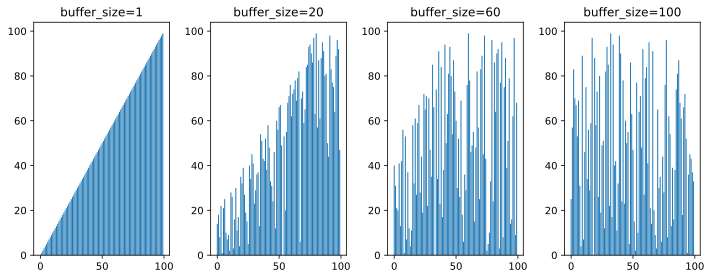

In [7]:
fig = plt.figure(figsize=(10, 4))
buffer_size = [1, 20, 60, 100]
for i in range(len(buffer_size)):
    shuffled_data = []
    ds_range = tf.data.Dataset.from_tensor_slices(tf.range(100))
    for x in ds_range.shuffle(buffer_size[i]).batch(1):
        shuffled_data.append(x.numpy()[0])

    ax = fig.add_subplot(1, 4, i+1)
    ax.bar(range(100), shuffled_data)
    ax.set_title(f"buffer_size={buffer_size[i]}")

plt.tight_layout()
plt.show()

Furthermore, `shuffle` has an important argument `reshuffle_each_iteration` that controls whether the shuffle order should be different each time the dataset is iterated over. This is set to `True` by default. 

In [8]:
dataset = tf.data.Dataset.range(3)
dataset = dataset.shuffle(3)
dataset = dataset.repeat(2)
list(dataset.as_numpy_iterator())

[1, 2, 0, 2, 0, 1]

In [9]:
dataset = tf.data.Dataset.range(3)
dataset = dataset.shuffle(3, reshuffle_each_iteration=False)
dataset = dataset.repeat(2)
list(dataset.as_numpy_iterator())

[1, 0, 2, 1, 0, 2]

### Creating epochs

When training a model for multiple epochs, we need to shuffle and iterate over the dataset by the desired number of epochs. To repeat the dataset, we use the `.repeat` method on the dataset object. The following pattern is the correct order of creating epochs. For training, it is recommended to set `drop_remainder=True` in `.batch()` to drop the last mini batch of size 1. 

In [10]:
buffer_size = 6
for x, t in ds_transformed.shuffle(buffer_size).batch(3).repeat(2):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  0.617630  0.198051  0.680551  1
1  0.648086  0.804997  0.424360  6
2  0.328851  0.846439  0.780650  5 

         X1        X2        X3  y
0  0.161272  0.760996  0.799045  3
1  0.230624  0.622954  0.000000  0
2  0.293409  0.296210  0.681352  4 

         X1        X2        X3  y
0  0.880433  0.898673  0.967588  7
1  0.000000  1.000000  1.000000  8
2  1.000000  0.630363  0.995186  9 

        X1   X2        X3  y
0  0.31629  0.0  0.303707  2 

         X1        X2        X3  y
0  0.230624  0.622954  0.000000  0
1  0.316290  0.000000  0.303707  2
2  0.293409  0.296210  0.681352  4 

         X1        X2        X3  y
0  0.161272  0.760996  0.799045  3
1  1.000000  0.630363  0.995186  9
2  0.000000  1.000000  1.000000  8 

         X1        X2        X3  y
0  0.617630  0.198051  0.680551  1
1  0.880433  0.898673  0.967588  7
2  0.648086  0.804997  0.424360  6 

         X1        X2       X3  y
0  0.328851  0.846439  0.78065  5 



To see this more transparently, consider the 1-dimensional dataset:

In [11]:
data = tf.data.Dataset.range(10).shuffle(6).batch(3).repeat(2)
list(data.as_numpy_iterator())

[array([3, 5, 7]),
 array([1, 9, 2]),
 array([0, 8, 6]),
 array([4]),
 array([0, 6, 7]),
 array([4, 2, 1]),
 array([5, 3, 9]),
 array([8])]

Note that using `.repeat` requires you to specify `steps_per_epoch` in the Keras `fit` function since we now have a long dataloader (for the reader not familiar with Keras, it will be discusssed later). A way to avoid this is to iterate over epoch numbers, and generating shuffled batches at each iteration. Again the default behavior of reshuffling at each iteration turns out to be very convenient.

In [12]:
# Define data loader outside training loop
dataset = tf.data.Dataset.range(10)
dataloader = dataset.shuffle(10).batch(3, drop_remainder=True)

# Train loop: iterate over data loader every epoch
num_epochs = 2
for i in range(num_epochs):
    print(f"\n[Epoch {i}]:")
    
    for x in dataloader:
        print("  ", x)


[Epoch 0]:
   tf.Tensor([1 2 3], shape=(3,), dtype=int64)
   tf.Tensor([4 9 7], shape=(3,), dtype=int64)
   tf.Tensor([8 6 5], shape=(3,), dtype=int64)

[Epoch 1]:
   tf.Tensor([0 4 1], shape=(3,), dtype=int64)
   tf.Tensor([3 9 7], shape=(3,), dtype=int64)
   tf.Tensor([8 2 5], shape=(3,), dtype=int64)


## Dataset from local files

For very large datasets, a good enough approach is to randomly shard the data into multiple files once before training, then shuffle the filenames uniformly. That is, instead of loading actual data into TF datasets, we can simply load references to it in the form of filenames, then we can load the data in batches during training and inference using `.map()`.

```{margin}
`kaggle/v1.5.12`
```

```bash
# Here e.g. https://www.kaggle.com/datasets/waifuai/cat2dog
USER="waifuai"
DATASET="cat2dog"
DATA_DIR=./data
mkdir ${DATA_DIR}
kaggle datasets download -d ${USER}/${DATASET} -p ${DATA_DIR}
unzip ${DATA_DIR}/${DATASET}.zip -d ${DATA_DIR}/${DATASET} > /dev/null
rm ${DATA_DIR}/${DATASET}.zip
```

```text
mkdir: ./data: File exists
Downloading cat2dog.zip to ./data
100%|██████████████████████████████████████| 27.4M/27.4M [00:09<00:00, 3.13MB/s]
```

We can get filenames using `.glob` on a `pathlib.Path` object as follows:

In [5]:
DATASET_DIR = Path("./data").absolute()
cat_imgdir_path = DATASET_DIR / "cat2dog" / "cat2dog" / "trainA"
dog_imgdir_path = DATASET_DIR / "cat2dog" / "cat2dog" / "trainB"

cat_file_list = sorted([str(path) for path in cat_imgdir_path.glob("*.jpg")])
dog_file_list = sorted([str(path) for path in dog_imgdir_path.glob("*.jpg")])

Visualizing image sets for cats and dogs:

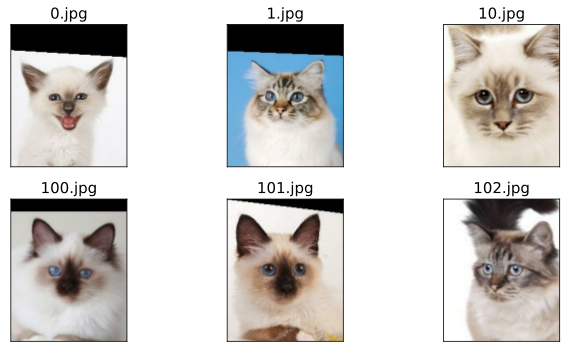

In [14]:
import pathlib

fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(cat_file_list[:6]):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(pathlib.Path(file).name, size=15)
    
plt.tight_layout()
plt.show()

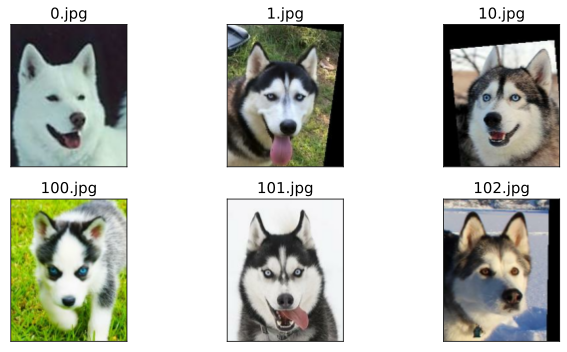

In [15]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(dog_file_list[:6]):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(pathlib.Path(file).name, size=15)
    
plt.tight_layout()
plt.show()

Instead of having a dataset of arrays for images, and their corresponding labels, we can create a dataset of filenames and their labels. Then, we can transform the filenames to images using a mapping to load and preprocess images given their filenames.

0


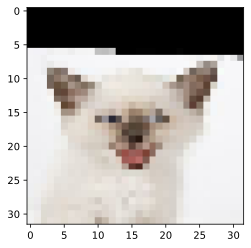

In [16]:
from functools import partial

# Define mapping function: (filename, label) -> (RGB array, label)
def load_and_preprocess(path, label, img_width=124, img_height=124):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img /= 255.0
    return img, label

# Create dataset of RGB arrays resized to 32x32x3
file_names = cat_file_list + dog_file_list
labels = [0] * len(cat_file_list) + [1] * len(dog_file_list)
file_names_ds = tf.data.Dataset.from_tensor_slices((file_names, labels))
images_dataset = file_names_ds.map(partial(load_and_preprocess, img_width=32, img_height=32))

# Display one image and its label (0 = cat, 1 = dog) 
img, label = next(iter(images_dataset.batch(1)))
print(label.numpy()[0])
plt.imshow(img[0, :, :, :]);

## Datasets from `tensorflow_datasets`

The `tensorflow_datasets` library provides a collection of freely available 
(well formatted) datasets for training or evaluating deep learning models which allows for quick 
experimentation. The datasets also come with an `info` dictionary which contains all relevant metadata.
Morevero, the datasets already load as a `Dataset` object. The list of all available datasets can be found in [this catalog](https://www.tensorflow.org/datasets/catalog/overview).

In [17]:
import tensorflow_datasets as tfds

print(len(tfds.list_builders())) # no. of available datasets
print(tfds.list_builders()[:5])

1033
['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']


Datasets from `tfds` can be loaded using three steps:

In [18]:
coil100_bldr = tfds.builder('coil100')                      
coil100_bldr.download_and_prepare()                         
coil100_ds = coil100_bldr.as_dataset(shuffle_files=True)

import json
json_info = json.loads(coil100_bldr.info.as_json)
print(json.dumps(json_info, indent=2))

{
  "citation": "@article{nene1996columbia,\n  title={Columbia object image library (coil-20)},\n  author={Nene, Sameer A and Nayar, Shree K and Murase, Hiroshi and others},\n  year={1996},\n  publisher={Technical report CUCS-005-96}\n}",
  "description": "The dataset contains 7200 color images of 100 objects\n(72 images per object). The objects have a wide variety of complex geometric and reflectance characteristics.\nThe objects were placed on a motorized turntable against a black background.\nThe turntable was rotated through 360 degrees to vary object pose with respect to a fxed color camera.\nImages of the objects were taken at pose intervals of\t5 degrees.This corresponds to\n72 poses per object",
  "downloadSize": "130688843",
  "fileFormat": "tfrecord",
  "location": {
    "urls": [
      "http://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php"
    ]
  },
  "moduleName": "tensorflow_datasets.image.coil100",
  "name": "coil100",
  "releaseNotes": {
    "1.0.0": "Initial r

We can see that the result is a dictionary:

In [19]:
print(coil100_ds)

{'train': <_OptionsDataset element_spec={'angle': TensorSpec(shape=(), dtype=tf.int64, name=None), 'angle_label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image': TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None), 'object_id': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


There is only train set in this dataset.

In [20]:
coil100_ds_trn = coil100_ds['train']
print(coil100_ds_trn)
print(isinstance(coil100_ds_trn, tf.data.Dataset))
print(len(coil100_ds_trn))

<_OptionsDataset element_spec={'angle': TensorSpec(shape=(), dtype=tf.int64, name=None), 'angle_label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image': TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None), 'object_id': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
True
7200


In [21]:
instance = next(iter(coil100_ds_trn))
print(type(instance))
print(instance.keys())

<class 'dict'>
dict_keys(['angle', 'angle_label', 'image', 'object_id'])


2022-04-28 22:59:44.535578: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Each element of this dataset is a dictionary, so we have to extract the features and labels using a mapping:

In [22]:
ds_train = coil100_ds_trn.map(lambda d: (
    {k: d[k] for k in d.keys() if k != 'object_id'},
    d['object_id']
))

# Try one example
features, labels = next(iter(ds_train.batch(8)))
print(features['angle'].shape)
print(features['angle_label'].shape)
print(features['image'].shape)
print(labels.numpy().shape)

(8,)
(8,)
(8, 128, 128, 3)
(8,)


2022-04-28 22:59:44.706009: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


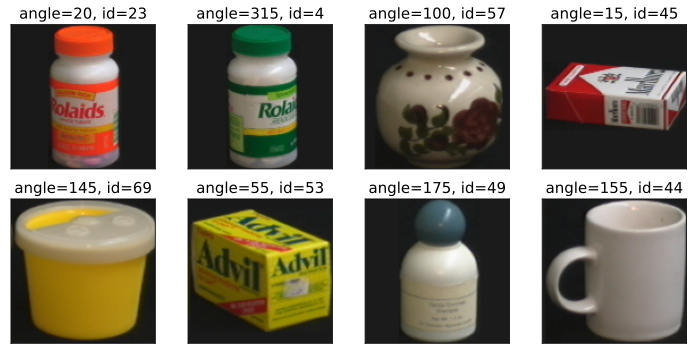

In [23]:
fig = plt.figure(figsize=(10, 5))
for i in range(8):
    img = features['image'][i, :, :, :]
    ax = fig.add_subplot(2, 4, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(f"angle={features['angle'][i]}, id={labels[i].numpy()}", size=15)
    
plt.tight_layout()
plt.show()

It turns out that `tfds` has a wrapper function called `load` that performs all the three steps. We will use this to fetch the MNIST dataset in one step:

In [24]:
MNIST, MNIST_info = tfds.load('mnist', with_info=True, shuffle_files=False)
print(MNIST_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/particle1331/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [25]:
train_dataset, test_dataset = MNIST['train'], MNIST['test']
train_dataset = train_dataset.map(lambda d: (d['image'], d['label']))
test_dataset = test_dataset.map(lambda d: (d['image'], d['label']))

print(type(train_dataset))
print(train_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<MapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


2022-04-28 22:59:45.295193: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


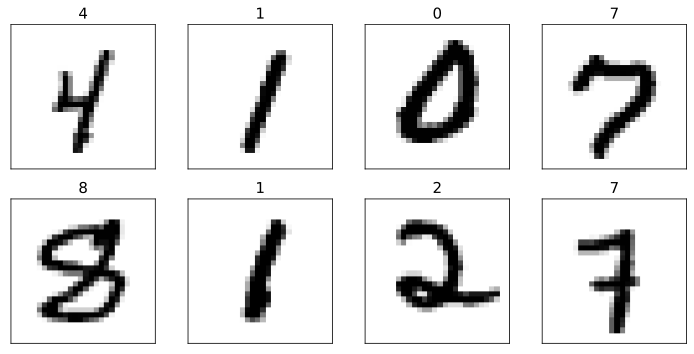

In [26]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataset.batch(8)))
fig = plt.figure(figsize=(10, 5))
for i in range(8):
    img = images[i, :, :, :]
    ax = fig.add_subplot(2, 4, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img, cmap='gray_r')
    ax.set_title(f"{labels[i].numpy()}", size=15)
    
plt.tight_layout()
plt.show()

## Training Keras models

```{margin}
⚠️ This section requires knowledge of the **Keras API** discussed [here](https://particle1331.github.io/inefficient-networks/notebooks/tf/02-mechanics.html#keras-api).
```

So far we have learned about the basic utility components of 
TensorFlow for manipulating tensors and organizing data into formats that we 
can iterate over during training. In this section, we look at how to feed data into TensorFlow models.

### Custom training loop

**Dataset.** In this section, we train a simple linear regression model derived from `tf.keras.Model` by implementing SGD from scratch. The loop iterates over a `tf.data.Dataset` object which acts as a data loader. We use a 2-layer MLP to learn the artificial dataset composed of 10 points below.

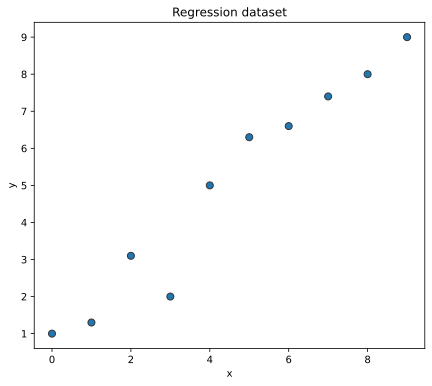

In [27]:
import numpy as np

X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

plt.figure(figsize=(7, 6), dpi=80)
plt.scatter(X_train, y_train, edgecolor="#333", s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression dataset')
plt.show()

In [28]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
ds_train_orig = tf.data.Dataset.from_tensor_slices((
    tf.cast(X_train_norm, tf.float32), 
    tf.cast(y_train, tf.float32)
))

<br>

**Model.** We implement a univariate linear regression model by subclassing the Keras `Model` class.

In [29]:
class RegressionModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')
    
    def call(self, x):
        return self.w * x + self.b

<br>

**Training loop.** The `train` function implements a single step of SGD optimization where gradients of the MSE loss function obtained automatically are used to update the weight `w` and bias `b`. Note that using `count=None` on `repeat` will create a batched version of the dataset that repeats infinitely many times. But since we implement no early stopping mechanism, we set `count=200` to train the model for 200 epochs. 

In [30]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        loss = loss_fn(model(inputs), outputs)
    
    dw, db = tape.gradient(loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)

Alternatively, we can exploit the `apply_gradients` method of built-in Keras optimizers:

```python
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
optimizer.apply_gradients(zip([dw, db], [model.w, model.b]))
```

Finally, we can implement the train loop by iterating over the batch loader and applying the train step at each iteration:

In [31]:
# Hyperparameters
NUM_EPOCHS = 200
LEARNING_RATE = 0.001
BATCH_SIZE = 1

# Instantiate model
model = RegressionModel()

# Create batch loader
ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.batch(1)
ds_train = ds_train.repeat(count=NUM_EPOCHS)

ws, bs = [], []
steps_per_epoch = np.floor(len(y_train) / BATCH_SIZE)
for i, batch in enumerate(ds_train):
    ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_value = loss_fn(model(bx), by)
    train(model, bx, by, learning_rate=LEARNING_RATE)
    
    if i%100==0:
        print(f'Epoch {i // int(steps_per_epoch):4d} Loss {loss_value:>8.4f}')


2022-04-28 22:59:46.027782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch    0 Loss   1.0000
Epoch   10 Loss   0.7545
Epoch   20 Loss  12.3543
Epoch   30 Loss  16.7208
Epoch   40 Loss   0.1441
Epoch   50 Loss   0.0592
Epoch   60 Loss   0.2374
Epoch   70 Loss   4.8255
Epoch   80 Loss   2.3959
Epoch   90 Loss   1.5433
Epoch  100 Loss   0.7149
Epoch  110 Loss   0.1239
Epoch  120 Loss   0.6282
Epoch  130 Loss   0.1058
Epoch  140 Loss   1.7988
Epoch  150 Loss   0.3787
Epoch  160 Loss   0.0044
Epoch  170 Loss   0.1000
Epoch  180 Loss   0.0015
Epoch  190 Loss   0.0559


<br>

**History.** Here we plot the learned model and the history of its parameters. As training progresses, the weight and bias converge to an optimal value.

Final Parameters: w=2.6577, b=4.8799


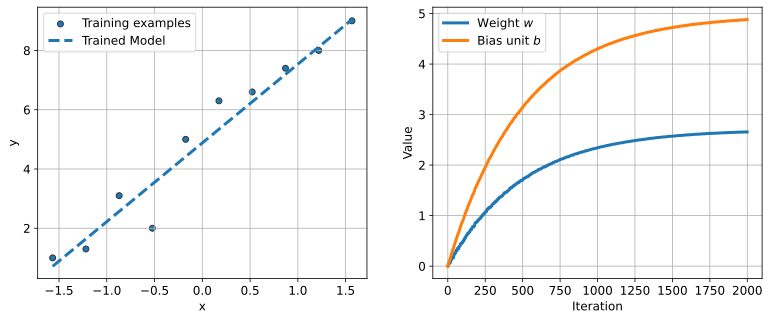

In [32]:
print(f'Final Parameters: w={model.w.numpy():.4f}, b={model.b.numpy():.4f}')

# Generate test set; here test = inference
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

# Get predictions on test set
y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))

# Plot learned model
fig = plt.figure(figsize=(13, 5), dpi=600)
ax = fig.add_subplot(1, 2, 1)
plt.scatter(X_train_norm, y_train, c="#1F77B4", edgecolor="#333")
plt.plot(X_test_norm, y_pred, linestyle="--", color='#1F77B4', lw=3)
plt.legend(['Training examples', 'Trained Model'], fontsize=12)
ax.set_xlabel('x', size=12)
ax.set_ylabel('y', size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid()

# Plot parameter history
ax = fig.add_subplot(1, 2, 2)
plt.plot(ws, lw=3)
plt.plot(bs, lw=3)
plt.legend([r'Weight $w$', r'Bias unit $b$'], fontsize=12)
ax.set_xlabel('Iteration', size=12)
ax.set_ylabel('Value', size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid()

plt.show()

### Keras `fit` function

In this section, we look at how to obtain a dataset from `tensorflow_datasets` and use it to train a Keras model. In particular we will use the Iris Dataset which consists of 150 observations of the petal and sepal lengths, and petal and sepal widths of 3 different types of irises.


<!-- ```{figure} ../../img/iris.jpeg
---
name: iris
---
From left to right: [Iris setosa](https://commons.wikimedia.org/w/index.php?curid=170298), [Iris versicolor](https://commons.wikimedia.org/w/index.php?curid=248095), and [Iris virginica](https://www.flickr.com/photos/33397993@N05/3352169862).
``` -->

In [33]:
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info.splits) 

{'train': <SplitInfo num_examples=150, num_shards=1>}


In [34]:
type(iris['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

<br>

**Dataset split.** This only has a train set, so we have to manually split for validation. We can do this with the `.take()` and `.skip()` methods. But this can lead to some unexpected behavior after calling `.shuffle` which converts the dataset to a `ShuffleDataset` which would shuffle the after the initial application of take when creating the train dataset. A workaround is to set `reshuffle_each_iteration` to `False`. 

In [35]:
tf.random.set_seed(1)

# Shuffle data
dataset_orig = iris['train']
N = len(dataset_orig)
dataset_shuffled = dataset_orig.shuffle(N, reshuffle_each_iteration=False)

# Split into train and test sets + transform
train_dataset = dataset_shuffled.take(100)
test_dataset  = dataset_shuffled.skip(100)
print("Train size:", len(train_dataset))
print("Test size: ", len(test_dataset))

train_dataset = train_dataset.map(lambda d: (d['features'], d['label']))
test_dataset  =  test_dataset.map(lambda d: (d['features'], d['label']))

Train size: 100
Test size:  50


<br>

**Model.** A two-layer MLP with sigmoid activations should suffice to learn 100 data points:

In [36]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')
])

iris_model.summary() # No need to call .build(), input_shape passed in first dense layer.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


<br>

**Training.** Observe that the Keras `fit` method works with `tf.data` batch loaders:

In [37]:
# Use sparse since targets are 0, 1, 2
iris_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Hyperparameters
NUM_EPOCHS = 50
BATCH_SIZE = 8

# This will be iterated over in the fit method.
train_loader = train_dataset.shuffle(buffer_size=100)
train_loader = train_loader.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_loader = train_loader.prefetch(buffer_size=10) # Prepare next elements 

# Train model
history = iris_model.fit(
    train_loader, 
    epochs=NUM_EPOCHS,
    verbose=1,
)

Epoch 1/50
12/12 [==============================] - 0s 4ms/step - loss: 1.0202 - accuracy: 0.5000
Epoch 2/50
 1/12 [=>............................] - ETA: 0s - loss: 0.9636 - accuracy: 0.6250

2022-04-28 22:59:51.692325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 4ms/step - loss: 0.8680 - accuracy: 0.7083
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7913 - accuracy: 0.6979
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7268 - accuracy: 0.7708
Epoch 5/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.8021
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6009 - accuracy: 0.7396
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.5622 - accuracy: 0.7812
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.7708
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.5010 - accuracy: 0.8229
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5125 - accuracy: 0.7292
Epoch 11/50
12/12 [==============================] - 0s 3ms/step - loss: 0.4868 - accuracy: 0.7812
Epoch 12/50
12/12 [==========

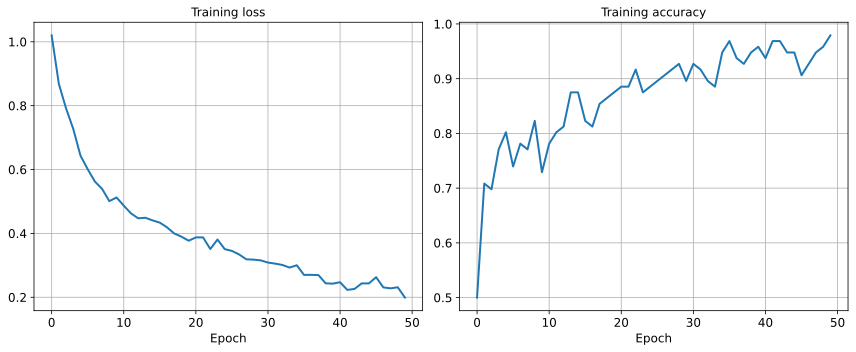

In [38]:
hist = history.history

# Train loss plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
ax[0].plot(hist['loss'], lw=2)
ax[0].set_title('Training loss', size=12)
ax[0].set_xlabel('Epoch', size=12)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()

# Accuracy plot
ax[1].plot(hist['accuracy'], lw=2)
ax[1].set_title('Training accuracy', size=12)
ax[1].set_xlabel('Epoch', size=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

plt.tight_layout()

<br>

**Evaluation.** Keras methods `evaluate` (and also `predict`) work nicely with TF dataset objects. We can load the test data into the evaluator as follows:

In [39]:
results = iris_model.evaluate(test_dataset.batch(1), verbose=0) # 50 batches of size 1
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.2446   Test Acc.: 0.9200


2022-04-28 22:59:54.910905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
